## Analysis of 18F-FDG administration system

An FDG-PET scan  (https://en.wikipedia.org/wiki/Positron_emission_tomography) is a routine diagnostic examination often used within clinical oncology. A PET scan is performed by injecting patients with an amount of radioactive 18F atoms that have been coupled to a glucose like molecule.  To administer the radioactive substance to the patient the hospital makes use of an automatic infusion system  similar to the one shown in the figure on the left. Within the infusion system a lead shielded vial of the radioactive 18F-FDG is stored and for each patient the right amount of radioactive tracer is dispensed. After the infusion the system automatically returns a report containing some information about the patient specific infusion process. An example of such a report is shown in the figure to the right. A first inspection of a set of these reports shows that for each patient the administration curve looks different.  Unfortunately it happens that the infusion system breaks down, for instance due to mechanical wear of certain components. This has happened a couple of times in recent years and we are wondering if the information contained in the infusion curves can be used to extract a parameter that can be used to predict imminent failure of the machine.

In medical imaging it is standard to use the DICOM standard for medical images. 
A dicom file consists of an image and a header containing relevant metadata of the scan such as patient name, name of the scanner etc.
The following code shows how to import and access the image and metadata part of a dicom file:

In [4]:
import pydicom as dcm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from os.path import dirname, join


myintego = dcm.read_file('Integodata/exampleAnonIntegoData')
print(myintego)

The pixel data is stored under the tag '7fe0,0010' but can also be accessed through the shortcut attribute "pixel_array":

In [8]:
sample = "anon_00a990e5-9e78-40f5-bf66-e4bf4af66d57"
myintego = dcm.read_file('Integodata/' + sample )
print(myintego)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0012) Instance Creation Date              DA: '20180504'
(0008, 0013) Instance Creation Time              TM: '085254'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.16.124.113531.4.7.1525416776716.1447737627.3
(0008, 0020) Study Date                          DA: '20180504'
(0008, 0021) Series Date                         DA: '20180504'
(0008, 0023) Content Date                        DA: '20180504'
(0008, 0030) Study Time                          TM: '000000'
(0008, 0031) Series Time                         TM: '085256'
(0008, 0033) Content Time                        TM: '085256'
(0008, 0050) Accession Number                    SH: '0253057269'
(0008, 0060) Modality                            CS: 'PT'
(0008, 0064) Conversion Type               

The pixel data is stored under the tag '7fe0,0010' but can also be accessed through the shortcut attribute "pixel_array":

In [102]:
img = myintego.pixel_array 


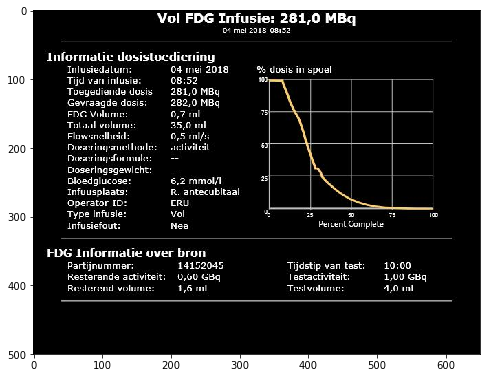

In [103]:
fig=plt.figure(figsize=(8, 8))
plt.imshow(img)

Below is a very simple function to extract the curve from the above image by looking in the right area and simply determining where the highest pixel intensity occurs.

In [13]:
def get_curve(medradarr):
    curveraw = medradarr[95:300,343:500,0]
    Y = []

    for i in range(np.shape(curveraw)[1]):

        Y.append(np.round(200 - np.argmax(np.convolve(curveraw[:,i],[5,5],mode='same')))) # of course you can change the convulution to obtain better results

    Y = Y/np.max(Y)

    return Y


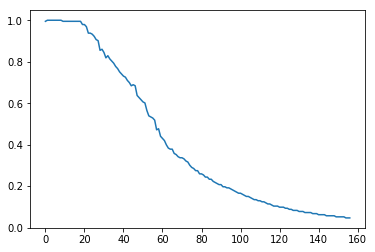

In [14]:
plt.plot(get_curve(img))

The big challenge now is that the image also contains additional text information about the dose used which is not in the dicom header but might be useful to us. Specifically there is a difference between the amount of radioactive tracer administered to the patient and the amount that was requested by the operator. We will use OCR functionality to obtain the requested amount.

To run this on your own machine you will need to install the Tesseract OCR engine and install the python pyocr wrapper to use it from within a notebook.


In [1]:
# import ocr_lib as ocr
from matplotlib import pyplot as plt
import numpy as np
import os
from skimage.color import rgb2gray

import pyocr
import pyocr.builders


ModuleNotFoundError: No module named 'ocr_lib'

'130,0'

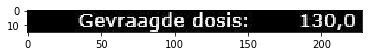

In [17]:

sec  = img[127:142,15:243]


plt.imshow(sec)


pytesseract.image_to_string(Image.fromarray(sec , 'RGB'), config= 'digits tessedit_char_whitelist=0123456789')
# pytesseract.image_to_string(Image.fromarray(rgb2gray(sec)))



In [ ]:

datadir = "Integodata/"

results = []

for filename in os.listdir(datadir):
    print('Processing:',filename)

    tmpdcm = dcm.read_file(datadir + filename)
    tmparr =  tmpdcm.pixel_array
    tmpcurve = get_curve(tmparr)
    
    tmpdims = np.shape(tmparr)
    tmparr = np.reshape(tmparr,(tmpdims[1],tmpdims[2],tmpdims[0])) 
    tmpdate = tmpdcm.StudyDate


    admdose = tmpdcm['0051','5102'].value

    print (tmpdate,admdose)


    try:
#         arr = tmpdcm.pixel_array
#         arr= arr.reshape(500,650,3)
        img = tmpdcm.pixel_array
#         img_gray=rgb2gray(arr)
            
        #ocrres = ocr.OCR(img_gray,[500-200,650-111,40,40])
#         ocrres = ocr.OCR(np.transpose(img_gray),[198,127,45,15])
        sec  =img[127:142,15:243]
        plt.imshow(sec)
        ocrres= pytesseract.image_to_string(Image.fromarray(sec , 'RGB'), config= 'digits tessedit_char_whitelist=0123456789')
        
        print(ocrres)
        reqdose = float(ocrres.replace(',','.'))
        difdose = reqdose - admdose
        reldifdose = difdose/reqdose

    except:
        reqdose = None
        difdose = None
        reldifdose = None

        
   
    results.append([tmpdate,admdose,reqdose,difdose,reldifdose,tmpcurve])


In [ ]:
results

In [207]:
import pandas as pd

In [214]:
df = pd.DataFrame(np.array(results), columns=['tmpdate','admdose','reqdose','difdose','reldifdose','tmpcurve'])
df

,tmpdate,admdose,reqdose,difdose,reldifdose,tmpcurve
0,20180409,120.526,None,None,None,"[0.9948186528497409, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,20171128,108.483,108,-0.482803,-0.0044704,"[0.9948186528497409, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,20180717,252.756,252,-0.755707,-0.00299884,"[0.9948186528497409, 1.0, 1.0, 0.9948186528497..."
3,20180702,143.13,144,0.869904,0.006041,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,20180504,281.049,282,0.951385,0.00337371,"[0.9948186528497409, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5,20180403,188.02,None,None,None,"[0.9948186528497409, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
6,20180814,133.785,136,2.2146,0.0162838,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
7,20180601,155.34,None,None,None,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
8,20180821,130.055,130,-0.0550995,-0.000423842,"[0.9948186528497409, 1.0, 1.0, 0.9948186528497..."
9,20180601,129.794,130,0.205795,0.00158304,"[0.9948186528497409, 1.0, 0.9948186528497409, ..."


In [209]:
df['reqdose'].isna().sum()

759

In [211]:
df_clean = df.dropna(axis=0, how='any', subset=['reqdose'])

In [212]:
df_clean

,tmpdate,admdose,reqdose,difdose,reldifdose,tmpcurve
1,20171128,108.483,108,-0.482803,-0.0044704,"[0.9948186528497409, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,20180717,252.756,252,-0.755707,-0.00299884,"[0.9948186528497409, 1.0, 1.0, 0.9948186528497..."
3,20180702,143.13,144,0.869904,0.006041,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,20180504,281.049,282,0.951385,0.00337371,"[0.9948186528497409, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
6,20180814,133.785,136,2.2146,0.0162838,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
8,20180821,130.055,130,-0.0550995,-0.000423842,"[0.9948186528497409, 1.0, 1.0, 0.9948186528497..."
9,20180601,129.794,130,0.205795,0.00158304,"[0.9948186528497409, 1.0, 0.9948186528497409, ..."
12,20180523,138.494,138.3,-0.193698,-0.00140056,"[0.9948186528497409, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
14,20180301,135.885,136,0.114899,0.000844843,"[0.9948186528497409, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
16,20180820,246.448,250,3.5518,0.0142072,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [215]:
import pickle
with open('2b.pickle', 'wb') as handle:
    pickle.dump([df,df_clean], handle, protocol=pickle.HIGHEST_PROTOCOL)